[Epoch 1, mb 50]    Avg.Loss = 0.690
 0.595

[Epoch 1] Avg.CrossEntropyLoss = 0.690    TotalLoss = 34.485    TrainingError = 40.50%    TestingError = 38.15%
[Epoch 2, mb 50]    Avg.Loss = 0.662
 0.6093

[Epoch 2] Avg.CrossEntropyLoss = 0.662    TotalLoss = 33.116    TrainingError = 39.07%    TestingError = 37.30%
[Epoch 3, mb 50]    Avg.Loss = 0.649
 0.6315

[Epoch 3] Avg.CrossEntropyLoss = 0.649    TotalLoss = 32.442    TrainingError = 36.85%    TestingError = 34.70%
[Epoch 4, mb 50]    Avg.Loss = 0.638
 0.6423

[Epoch 4] Avg.CrossEntropyLoss = 0.638    TotalLoss = 31.881    TrainingError = 35.77%    TestingError = 33.35%
[Epoch 5, mb 50]    Avg.Loss = 0.629
 0.6441

[Epoch 5] Avg.CrossEntropyLoss = 0.629    TotalLoss = 31.460    TrainingError = 35.59%    TestingError = 33.55%
[Epoch 6, mb 50]    Avg.Loss = 0.622
 0.657

[Epoch 6] Avg.CrossEntropyLoss = 0.622    TotalLoss = 31.103    TrainingError = 34.30%    TestingError = 32.10%
[Epoch 7, mb 50]    Avg.Loss = 0.616
 0.659

[Epoch 7]

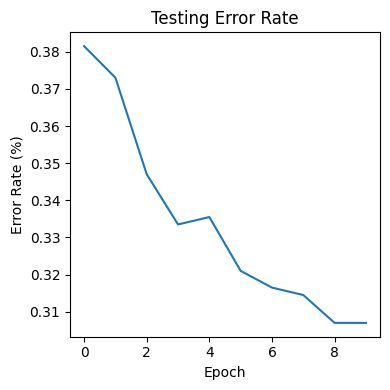

In [8]:
from __future__ import division
from __future__ import print_function

import sys
try:
   import _pickle as pickle
except:
   import pickle

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# This is a class for a LinearTransform layer which takes an input
# weight matrix W and computes W x as the forward step
class LinearTransform(object):

    def __init__(self, W, b):
        self.W = W # hidden x input
        self.b = b # hidden x 1
        self.inp = None
        self.W_V = np.zeros_like(W)
        self.b_V = np.zeros_like(b)

    def forward(self, x, train): # x => n x input
        if train:
            self.inp = x
        out = np.matmul(self.W, x.T) + self.b

        return out.T

    def grad_input(self):
        grad = []
        for i in range(self.inp.shape[0]):
            grad.append(self.W.copy())

        return np.stack(grad)

    def grad_W(self):
        out, inp = self.W.shape
        n, f = self.inp.shape
        grad = []
        assert inp == f
        for k in range(n):
            gradi = np.zeros((out, out*inp), dtype=np.float32)
            for i in range(out):
                s = i*inp
                gradi[i, s:s+inp] = self.inp[k]
#             gradi = self.inp[k].reshape(1, -1)
            grad.append(gradi)
        grad = np.stack(grad)
        return grad

    def grad_b(self):
        grad = []
        out, _ = self.b.shape
        n, _ = self.inp.shape
        for i in range(n):
            grad.append(np.identity(out, dtype=np.float32))

        return np.stack(grad)

    def __repr__(self):
        hidden, inp = self.W.shape
        return f'Linear {inp}x{hidden}'


    def backward(
        self,
        grad_output,
        learning_rate,
        momentum,
        l2_penalty,
    ):
        grad_inp = self.grad_input()
        grad_w = self.grad_W()
        grad_b = self.grad_b()
        n = grad_inp.shape[0]
        grads = []
        for i in range(n):
            grads.append(np.matmul(grad_output[i].reshape(1,-1), grad_inp[i]))

        grads = np.stack(grads)


        gradsW = []
        gradsb = []
        for i in range(n):
            gradsW.append(np.matmul(grad_output[i].reshape(1,-1), grad_w[i]))
            gradsb.append(np.matmul(grad_output[i].reshape(1,-1), grad_b[i]))

        gradsW = np.stack(gradsW)
        gradsb = np.stack(gradsb)

        self.inp = None

        self.update_params(gradsW, gradsb, learning_rate, momentum, l2_penalty)

        return grads

    def update_params(self, grad_w, grad_b, learning_rate, momentum, l2_penalty):
        out, inp = self.W.shape
        n = out*inp

#         print(np.mean(grad_w, axis=0).shape)


        gradw = np.mean(grad_w, axis=0).reshape(*(self.W.shape)) + (l2_penalty/n * self.W)
        gradb = np.mean(grad_b, axis=0).reshape(*(self.b.shape))

        self.W_V = momentum*self.W_V + (1-momentum)*gradw
        self.b_V = momentum*self.b_V + (1-momentum)*gradb

        self.W = self.W - learning_rate*self.W_V
        self.b = self.b - learning_rate*self.b_V




# This is a class for a ReLU layer max(x,0)
class ReLU(object):
    def __init__(self):
        self.inp = None

    def forward(self, x, train):
        if train:
            self.inp = x[:]
        return np.maximum(x, 0)

    def grad_input(self):
        n, f = self.inp.shape
        grad = []

        for i in range(n):
            gradi = np.identity(f, dtype=np.float32)
            x = np.ones(f, dtype=np.float32)
            x[self.inp[i]<=0] = 0
            gradi[np.arange(f), np.arange(f)] = x
            grad.append(gradi)

        return np.stack(grad)

    def backward(
        self,
        grad_output,
        learning_rate=0.0,
        momentum=0.0,
        l2_penalty=0.0,
    ):
        grad_inp = self.grad_input()
        n = grad_inp.shape[0]
        grads = []
        for i in range(n):
            grads.append(np.matmul(grad_output[i].reshape(1,-1), grad_inp[i]))

        self.inp = None
        return np.stack(grads)


class SigmoidCrossEntropy(object):

    def __init__(self):
        self.inp = None
        self.inp_label = None

    def forward(self, x, y, train=False):
        # DEFINE forward function
        if train:
            self.inp = x.copy()
            self.inp_label = y
        p_x = self.sigmoid(x)
        assert p_x.shape == y.shape
        l = np.zeros_like(y, dtype=np.float32)
        l[y==1] = -np.log(p_x[y==1] + 1e-10)
        l[y==0] = -np.log(1-p_x[y==0] + 1e-10)

        return l.mean()

    def sigmoid(self, x):
        return 1/(1+np.e**(-x))

    def grad_input(self):
        p_x = self.sigmoid(self.inp)
        assert p_x.shape == self.inp_label.shape
        g = (p_x - self.inp_label).reshape(-1,1)
        return g

    def backward(
        self,
        grad_output=None,
        learning_rate=0.0,
        momentum=0.0,
        l2_penalty=0.0
    ):
        grad_inp =  self.grad_input()
        self.inp = None
        self.inp_label = None

        return grad_inp

# This is a class for the Neural Network
class Net(object):

    def __init__(self, input_dims, hidden_units):
        self.layer1 = LinearTransform(np.random.normal(scale=1e-1, size=(hidden_units, input_dims)), np.random.randn(*(hidden_units, 1)))
#         self.layer1 = LinearTransform(np.random.normal(scale=1e-2, size=(1, input_dims)), np.zeros((1, 1), dtype=np.float32))
        self.layer2 = LinearTransform(np.random.normal(scale=1e-1, size=(1, hidden_units)), np.random.randn(*(1, 1)))

        self.act1 = ReLU()

#         self.layers = [self.layer1, self.layer2]
        self.layers = [self.layer1, self.act1, self.layer2]

        self.loss = SigmoidCrossEntropy()


    def forward(self, x, train=False):

        for layer in self.layers:
            x = layer.forward(x, train=train)

        return x

    def backward(self, grad_output, learning_rate, momentum, l2_penalty):
        for layer in self.layers[::-1]:
            grad_output = layer.backward(grad_output, learning_rate, momentum, l2_penalty)

        return grad_output

    def train(
        self,
        x_batch,
        y_batch,
        learning_rate,
        momentum,
        l2_penalty,
    ):
        out = self.forward(x_batch, train=True)
        loss = self.loss.forward(out, y_batch, train=True)
        grad_output  = self.loss.backward(learning_rate)
        self.backward(grad_output, learning_rate, momentum, l2_penalty)

        return loss

    def evaluate(self, x, y, thresh=0.5):
        y_pred = self.predict(x) >= thresh
        assert y_pred.shape == y.shape, f'{y_pred.shape}, {y.shape}'
        return (y_pred == y).mean()

    def predict(self, x):
        out = self.forward(x)
        return self.loss.sigmoid(out)

if __name__ == '__main__':
    if sys.version_info[0] < 3:
        data = pickle.load(open('cifar_2class_py2.p', 'rb'))
        train_x = data['train_data']
        train_y = data['train_labels']
        test_x = data['test_data']
        test_y = data['test_labels']
    else:
        data = pickle.load(open('cifar_2class_py2.p', 'rb'), encoding='bytes')
        train_x = data[b'train_data']
        train_y = data[b'train_labels']
        test_x = data[b'test_data']
        test_y = data[b'test_labels']

    num_examples, input_dims = train_x.shape



    #Normalize the data
    min_x = np.reshape(np.amin(train_x,axis=1),(num_examples,1));
    max_x = np.reshape(np.amax(train_x,axis=1),(num_examples,1));
    min_array = np.tile(min_x,input_dims);
    max_array = np.tile(max_x,input_dims);
    train_x = np.true_divide((train_x - min_array),(max_array - min_array));


    min_x = np.reshape(np.amin(test_x,axis=1),(test_x.shape[0],1));
    max_x = np.reshape(np.amax(test_x,axis=1),(test_x.shape[0],1));
    min_array = np.tile(min_x,input_dims);
    max_array = np.tile(max_x,input_dims);
    test_x = np.true_divide((test_x - min_array),(max_array - min_array));


    loss = SigmoidCrossEntropy()


    # # INSERT YOUR CODE HERE
    # # YOU CAN CHANGE num_epochs AND num_batches TO YOUR DESIRED VALUES
    num_epochs = 10
    # num_batches = 100
    hidden_units = 15
    learning_rate = 0.01
    # batch_size = int(train_x.shape[0]//num_batches)
    batch_size = 200 # mini_batch size
    num_batches = int(train_x.shape[0]//batch_size)
    nnet = Net(input_dims, hidden_units)
    momemtum = 0.8
    # print(ReLU().forward(np.array([1,2,3, -3, -1, 0, 2])))

    train_losses = []
    total_losses = []
    train_errors = []
    test_errors = []

    for epoch in range(num_epochs):

        indexes = np.arange(train_x.shape[0])
        np.random.shuffle(indexes)

    # # INSERT YOUR CODE FOR EACH EPOCH HERE

        total_loss = []
        for b in range(num_batches):
            # total_loss = 0.0
            x_batch = train_x[indexes[b*batch_size:(b+1)*batch_size]]
            y_batch = train_y[indexes[b*batch_size:(b+1)*batch_size]]
            loss = nnet.train(x_batch, y_batch, learning_rate, momentum=momemtum, l2_penalty=0.0001)
            # INSERT YOUR CODE FOR EACH MINI_BATCH HERE
            # MAKE SURE TO UPDATE total_loss
            total_loss.append(loss)
            print(
                '\r[Epoch {}, mb {}]    Avg.Loss = {:.3f}'.format(
                    epoch + 1,
                    b + 1,
                    np.mean(total_loss),
                ),
                end='',
            )
    #     # INSERT YOUR CODE AFTER ALL MINI_BATCHES HERE
    #     # MAKE SURE TO COMPUTE train_loss, train_error, test_loss, test_error
        print('\n', nnet.evaluate(train_x, train_y))
        # print(model.predict(train_x[:10]))
        # print(model.predict(train_x[:10]).astype(np.float16), train_y[:10])
        print()
        avg_loss = np.mean(total_loss)
        train_losses.append(avg_loss)
        total_losses.append(np.sum(total_loss))
        train_errors.append(1.0 - nnet.evaluate(train_x, train_y))

        test_error = 1.0 - nnet.evaluate(test_x, test_y)
        test_errors.append(test_error)

        # Print and display metrics
        print(
            '[Epoch {}] Avg.CrossEntropyLoss = {:.3f}    TotalLoss = {:.3f}    TrainingError = {:.2f}%    TestingError = {:.2f}%'.format(
                epoch + 1, avg_loss, np.sum(total_loss), train_errors[-1] * 100, test_errors[-1]* 100
            )
        )
        # print('    Train Loss: {:.3f}    Train Error: {:.2f}%'.format(
        #     train_loss,
        #     100. * 0,
        # ))
        # print('    Test Loss:  {:.3f}    Test Error:  {:.2f}%'.format(
        #     test_loss,
        #     100. * 0,
        # ))
    plt.figure(figsize=(4, 4))

    # Plot Cross-Entropy Loss
    # plt.subplot(1, 4, 1)
    # plt.plot(train_losses)
    # plt.title('Cross-Entropy Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')

    # # Plot Total Loss
    # plt.subplot(1, 4, 2)
    # plt.plot(total_losses)
    # plt.title('Total Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Total Loss')

    # # Plot Training Error Rate
    # plt.subplot(1, 4, 3)
    # plt.plot(train_errors)
    # plt.title('Training Error Rate')
    # plt.xlabel('Epoch')
    # plt.ylabel('Error Rate (%)')

    # #    Plot Testing Error Rate
    # plt.subplot(1, 4, 4)
    plt.plot(test_errors)
    plt.title('Testing Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Error Rate (%)')

    plt.tight_layout()
    plt.show()